## 02 Forecasting

### Overview

In [2]:
import numpy as np
import pandas as pd
import ibis
import matplotlib.pyplot as plt
import methods.prep as prep
import methods.vis as vis
import methods.fc as fc
import importlib

### Load Data

In [3]:
con = ibis.connect("duckdb://")
data = ibis.read_csv('data_forecasting/data.csv')

Dev/Test Split

In [4]:
# Split the data into model development (training + validation) (2007-01-01 to 2019-12-31) 
dev_data = data.filter(data.DATE.year() >= 2007).filter(data.DATE.year() <= 2019)

# and holdout test set (2020-01-01 to the end of the dataset in late 2024)
test_data = data.filter(data.DATE.year() >= 2020)

### Annual Decomposition

To check for seasonality, a look at an annual decomposition of the price of copper futures.

There might well be some seasonal effects in price level, but if so, they seem subtle.

In [5]:
importlib.reload(prep)
annual_decomp_features = [
    'COPPER_OPEN_NOMINAL'
]
annual_decomp = prep.annual_decomposition(
    dev_data,
    decomp_features=annual_decomp_features
)
annual_decomp.to_pandas().sort_values('DATE').head()

,DATE,COPPER_OPEN_NOMINAL,2008_COPPER_OPEN_NOMINAL,2009_COPPER_OPEN_NOMINAL,2010_COPPER_OPEN_NOMINAL,2011_COPPER_OPEN_NOMINAL,2012_COPPER_OPEN_NOMINAL,2013_COPPER_OPEN_NOMINAL,2014_COPPER_OPEN_NOMINAL,2015_COPPER_OPEN_NOMINAL,2016_COPPER_OPEN_NOMINAL,2017_COPPER_OPEN_NOMINAL,2018_COPPER_OPEN_NOMINAL,2019_COPPER_OPEN_NOMINAL
364,2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.643
141,2000-01-02,2.871,3.0410,1.3955,NaN,NaN,NaN,3.6510,3.3985,2.8255,NaN,NaN,3.2845,2.665
124,2000-01-03,2.798,3.0625,NaN,NaN,4.4550,3.454,3.7315,3.3850,NaN,NaN,2.507,3.2560,2.608
113,2000-01-04,2.660,3.1820,NaN,3.3500,4.4345,3.521,3.6935,NaN,NaN,2.1335,2.488,3.2365,2.589
315,2000-01-05,2.611,NaN,1.4690,3.4135,4.3830,3.434,NaN,NaN,2.8140,2.0825,2.557,3.2575,NaN


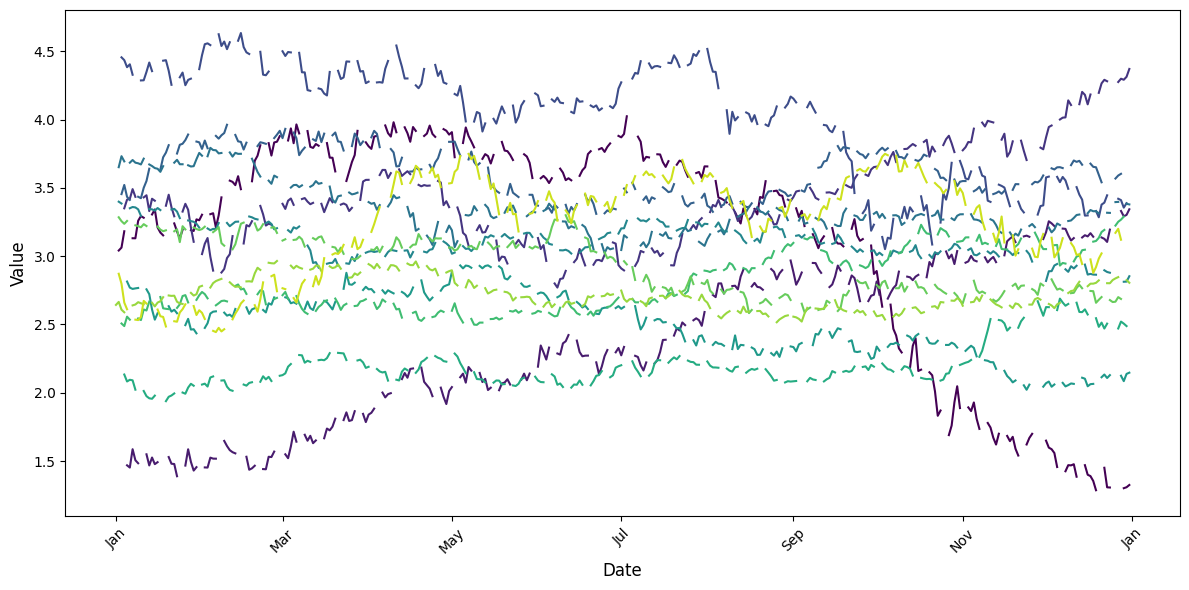

In [6]:
importlib.reload(vis)
vis.plot_decomp(
    annual_decomp,
    colormap='viridis')

### Stationarity Analysis

For forecasting, features should be stationary, meaning that no significant trends or seasonal patterns should be present in the data.  The mean and variance should be consistent throughout the time period.

No features are stationary without differencing.  The trends are enormous, and while it's difficult to see, some degree of seasonality is almost certainly present.  Many of these look pretty good at first differencing, but we'll want to do additional tests to be confident.

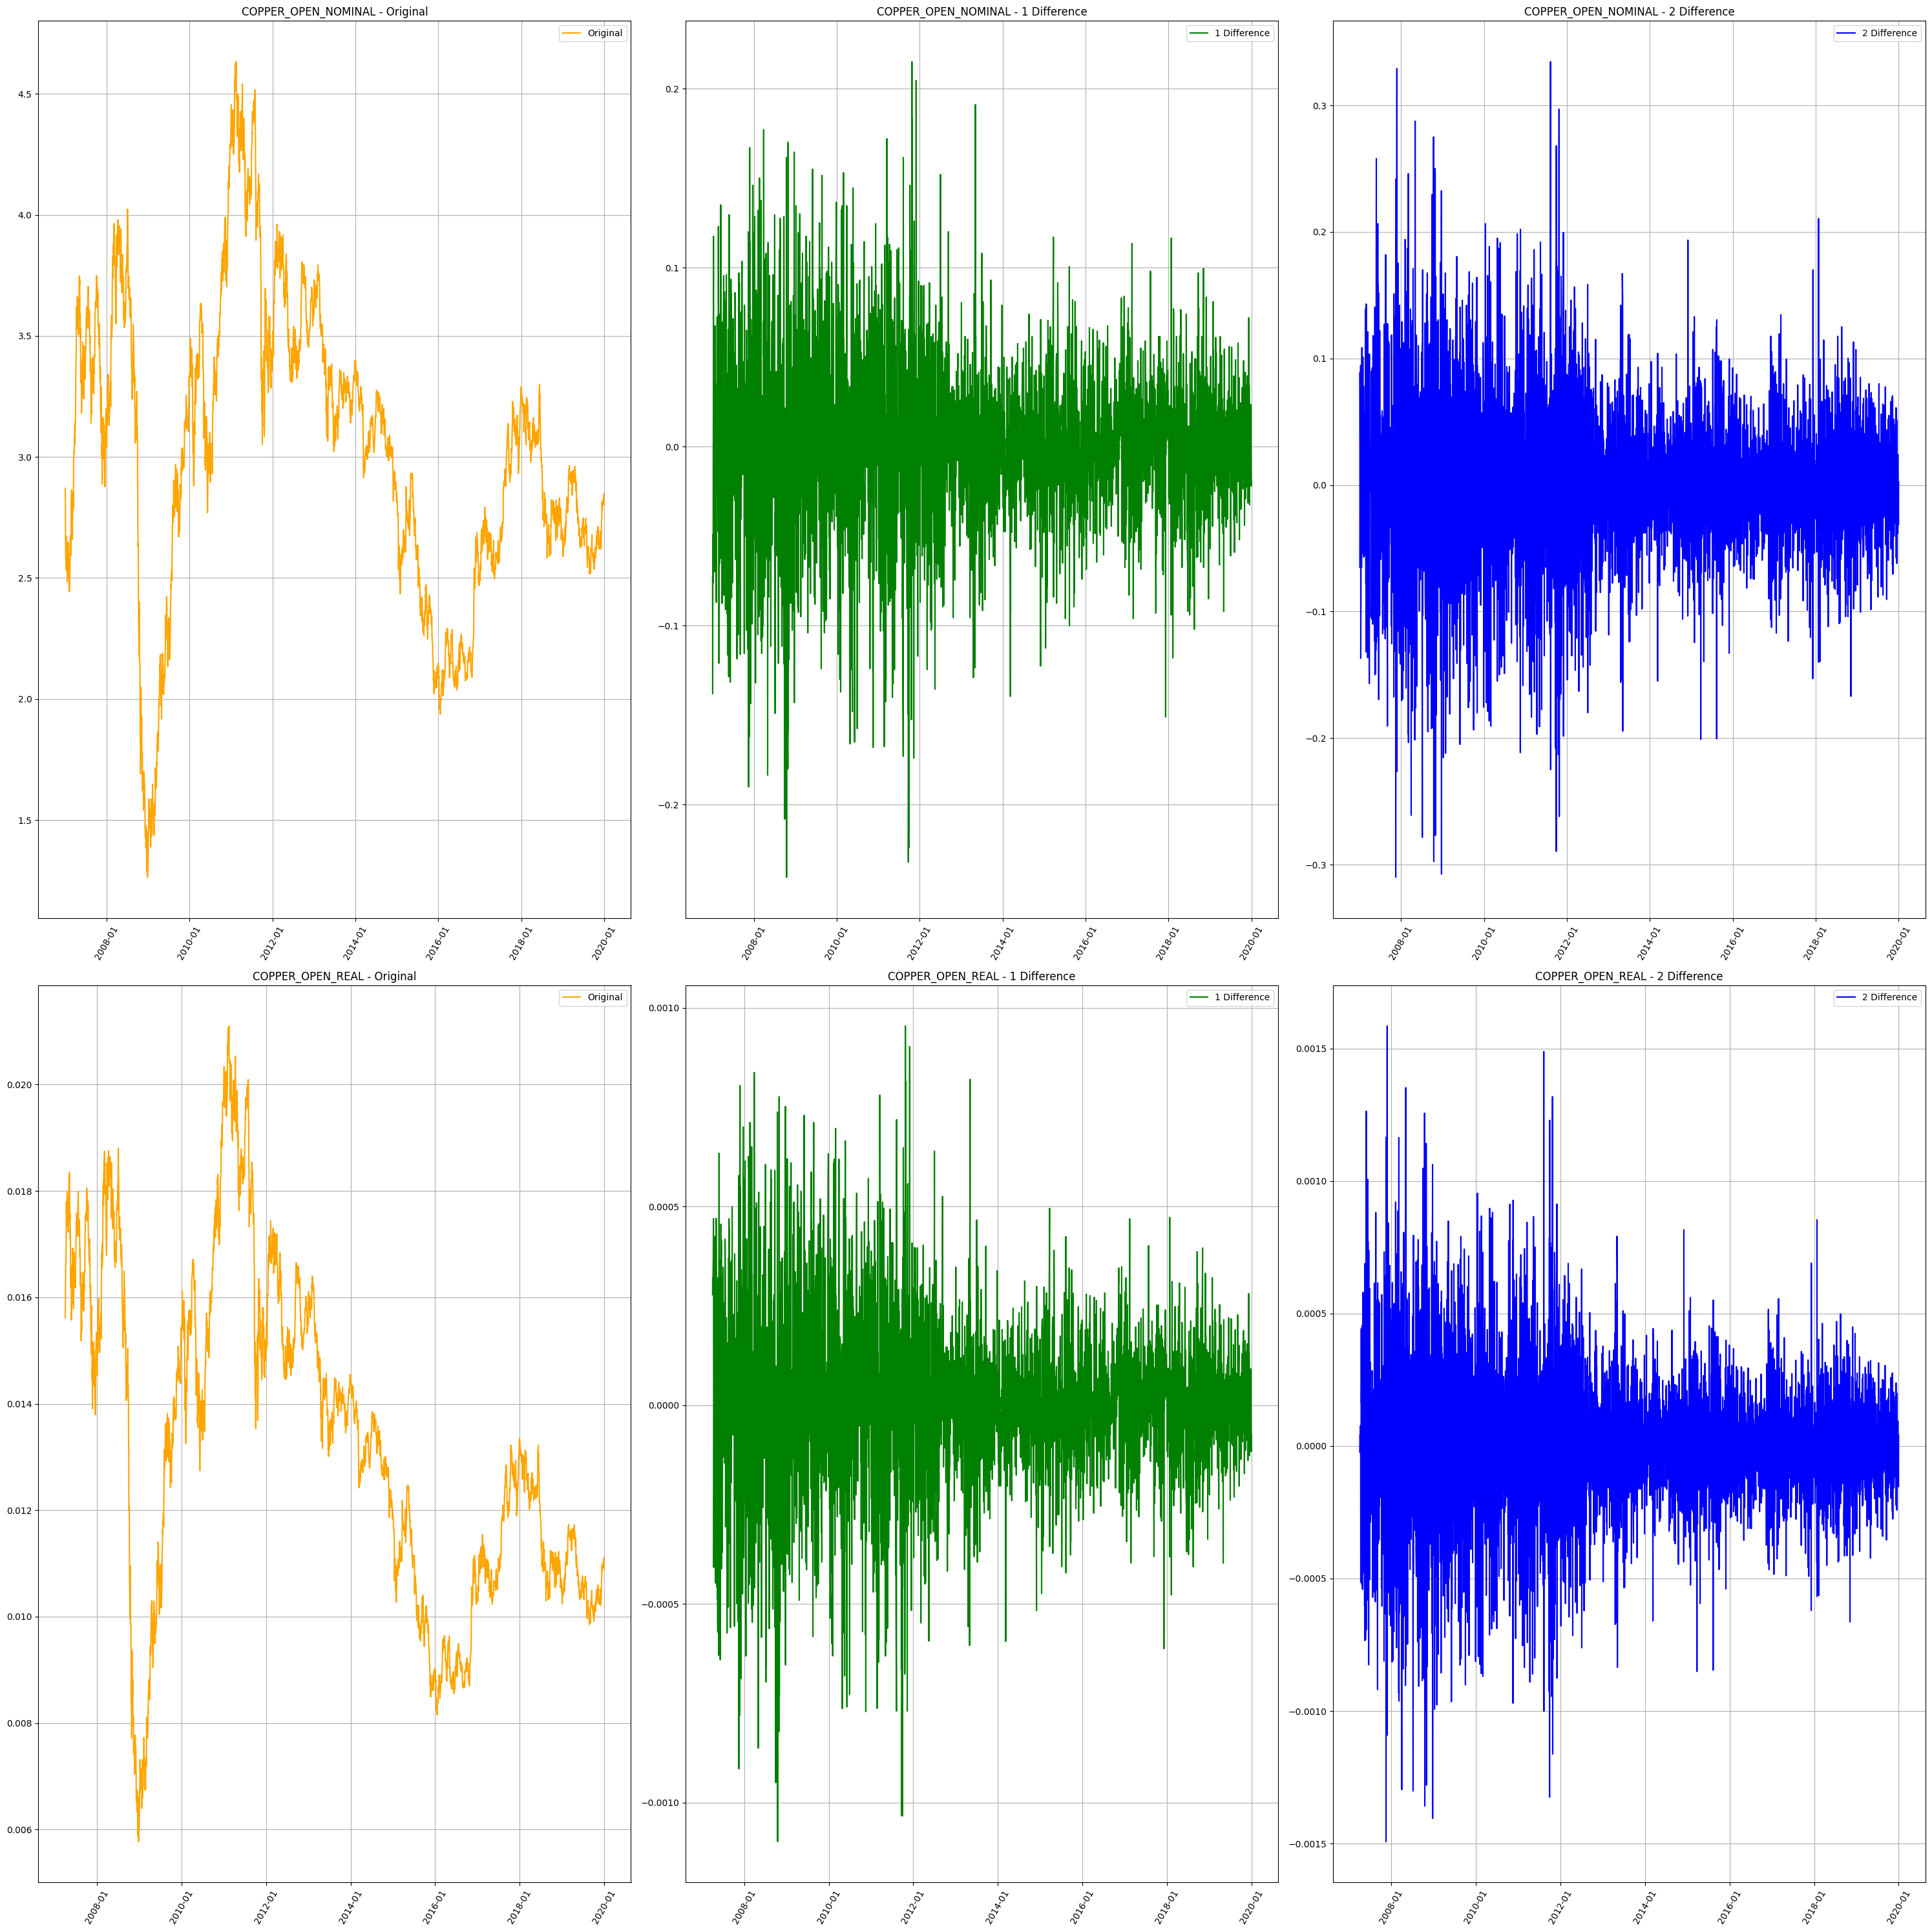

In [7]:
column_list = [
    'DATE',
    'COPPER_OPEN_NOMINAL',
    'COPPER_OPEN_REAL'
]
df = dev_data.select(column_list).to_pandas()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
fig, axes = vis.plot_time_series_diffs(
    df, 
    num_diffs = 2)

### Common Stationarity Tests

##### ADF Test  
Functions and interpretation from [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

This statistical test checks for a unit root.  If we fail to reject the null hypothesis, the series may be nonstationary.  In this case, the p-value is about 0.19 without differencing and 0.00000 differenced once, suggesting that differencing once is probably appropriate. 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


In [9]:
from statsmodels.tsa.stattools import kpss

df = dev_data.to_pandas().sort_values('DATE')[['DATE','COPPER_OPEN_NOMINAL']]
adf_test(df['COPPER_OPEN_NOMINAL'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.471315
p-value                           0.122611
#Lags Used                       21.000000
Number of Observations Used    3275.000000
Critical Value (1%)              -3.432348
Critical Value (5%)              -2.862423
Critical Value (10%)             -2.567240
dtype: float64


In [ ]:
# Differenced once
adf_test(df['COPPER_OPEN_NOMINAL'].diff().dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -59.239324
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3295.000000
Critical Value (1%)              -3.432336
Critical Value (5%)              -2.862418
Critical Value (10%)             -2.567237
dtype: float64


##### KPSS Test
Functions and interpretation from [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In this test, the null and alternate hypothesis are reversed: if we reject the null hypothesis, we have evidence that the series is not stationary.  The p-values here are 'higher than 0.01' without differencing and 'higher than 0.1' differenced once, so we can be reasonably confident in rejecting the null hypothesis differencing once.

In [11]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value

    print(kpss_output)

In [12]:
df = dev_data.to_pandas().sort_values('DATE')[['DATE','COPPER_OPEN_NOMINAL']]
kpss_test(df['COPPER_OPEN_NOMINAL'])

Results of KPSS Test:
Test Statistic            1.588498
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\haits\AppData\Local\Temp\ipykernel_20832\721547482.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
# Differenced once
kpss_test(df['COPPER_OPEN_NOMINAL'].diff().dropna())

Results of KPSS Test:
Test Statistic           0.054944
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\haits\AppData\Local\Temp\ipykernel_20832\721547482.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### Attempt Long-Term Models

Key tools:
- [skforecast](https://skforecast.org/)
- [pmdarima](https://github.com/alkaline-ml/pmdarima)
- [sklearn scaling]()

In [14]:
from skforecast.sarimax import Sarimax

##### Train / Validate Split

In [15]:
# Split the data into training data (2007-2018) 
train_data = dev_data.filter(dev_data.DATE.year() >= 2007).filter(dev_data.DATE.year() <= 2018)

# and validation set (2019 only)
val_data = dev_data.filter(dev_data.DATE.year() == 2019)

In [16]:
train_df = train_data.to_pandas()
train_df['DATE'] = pd.to_datetime(train_df['DATE'])
train_df = train_df.sort_values('DATE')

In [17]:
val_df = val_data.to_pandas()
val_df['DATE'] = pd.to_datetime(val_df['DATE'])
val_df = val_df.sort_values('DATE')

##### Pure ARIMA models

PDQ = 1,1,1

In [18]:

pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = train_df['COPPER_OPEN_NOMINAL'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     COPPER_OPEN_NOMINAL   No. Observations:                 3032
Model:                SARIMAX(1, 1, 1)   Log Likelihood                4800.190
Date:                 Sun, 08 Dec 2024   AIC                          -9594.379
Time:                         16:51:37   BIC                          -9576.330
Sample:                              0   HQIC                         -9587.890
                                - 3032                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1470      0.442     -0.332      0.740      -1.014       0.720
ma.L1          0.1166      0.444      0.262      0.793      -0.754       0.987
sigma2         0.0025   4.58e-05     53.772      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               446.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred = model.predict(steps = len(val_df))
pred.head()

,pred
3032,2.682560
3033,2.682551
3034,2.682553
3035,2.682552
3036,2.682552


In [20]:
type(pred)

pandas.core.frame.DataFrame

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Date', ylabel='Value'>)

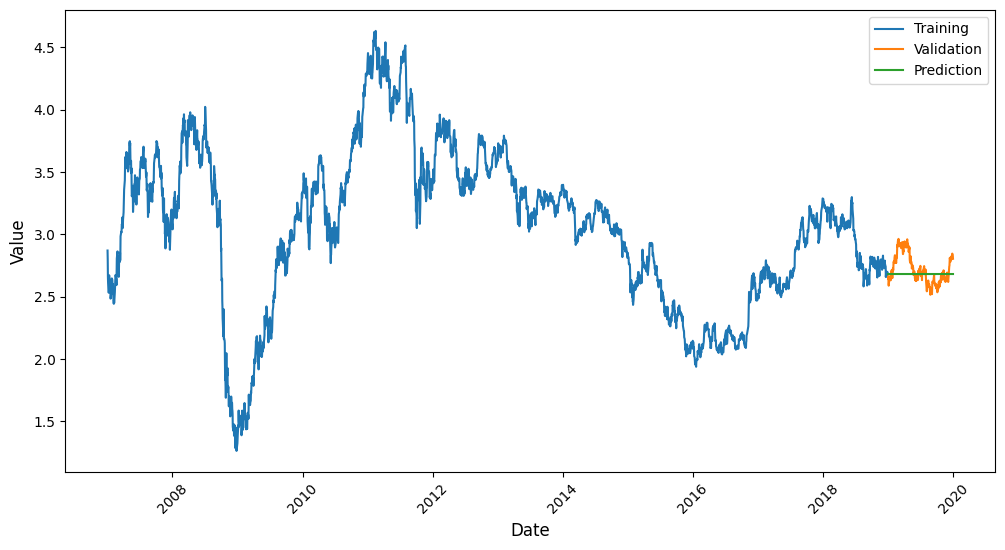

In [25]:
importlib.reload(vis)
vis.plot_train_pred_test(
    train_dates =train_df['DATE'],
    train_data = train_df['COPPER_OPEN_NOMINAL'],
    test_dates = val_df['DATE'],
    test_data = val_df['COPPER_OPEN_NOMINAL'],
    pred_dates = val_df['DATE'],
    pred_data = pred['pred']
)

# fig, ax=plt.subplots(figsize=(12, 6))

# plt.plot(train_df['DATE'],
#     train_df['COPPER_OPEN_NOMINAL'],
#     label = 'Training')

# plt.plot(val_df['DATE'],
#     val_df['COPPER_OPEN_NOMINAL'],
#     label = 'Validation')

# plt.plot(val_df['DATE'],
#          pred['pred'],
#          label = 'Prediction')

# ax.legend()

PDQ = 1,2,1

In [26]:
pdq = (1,2,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(y = train_df['COPPER_OPEN_NOMINAL'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     COPPER_OPEN_NOMINAL   No. Observations:                 3032
Model:                SARIMAX(1, 2, 1)   Log Likelihood                4794.033
Date:                 Sun, 08 Dec 2024   AIC                          -9582.067
Time:                         17:01:58   BIC                          -9564.018
Sample:                              0   HQIC                         -9575.578
                                - 3032                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0301      0.015     -2.054      0.040      -0.059      -0.001
ma.L1         -1.0000      0.051    -19.671      0.000      -1.100      -0.900
sigma2         0.0025      0.000     18.524      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               456.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
pred = model.predict(steps = len(val_df))

(<Figure size 1200x600 with 1 Axes>, <Axes: xlabel='Date', ylabel='Value'>)

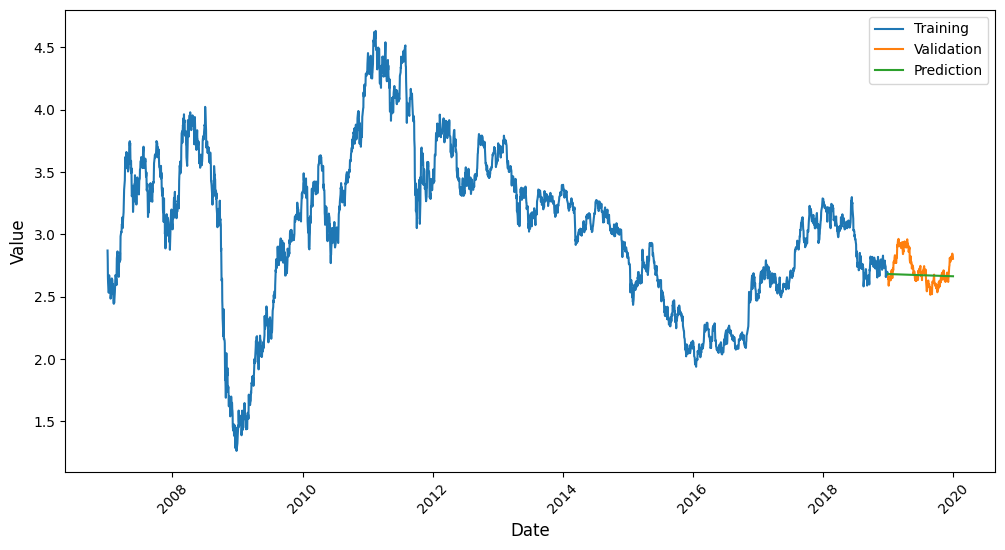

In [29]:
importlib.reload(vis)
vis.plot_train_pred_test(
    train_dates =train_df['DATE'],
    train_data = train_df['COPPER_OPEN_NOMINAL'],
    test_dates = val_df['DATE'],
    test_data = val_df['COPPER_OPEN_NOMINAL'],
    pred_dates = val_df['DATE'],
    pred_data = pred['pred']
)


##### Simple ARIMAX model

TODO 

In [ ]:
df = dev_data.to_pandas()
exog_cols = [col for col in df.columns if '_OPEN' in col]
exog = df[exog_cols]

In [ ]:
pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = df['COPPER_PRICE'],
    exog = exog)
model.summary()

In [ ]:
df = dev_data.to_pandas()
(df['COPPER_OPEN'] - df['COPPER_OPEN'].mean())/df['COPPER_OPEN'].std()

In [ ]:
df = dev_data.to_pandas()
exog_cols = [col for col in df.columns if '_OPEN' in col]
exog = df[exog_cols]
exog = exog.drop(['NATGAS_OPEN','GOLD_OPEN','CORN_OPEN'], axis='columns')
exog = (exog - exog.mean())/exog.std()

target = df['COPPER_PRICE']
target = (target - target.mean())/target.std()

pdq = (1,1,1) # p autoregression lags, d differences, q moving average
model = Sarimax(order = pdq)
model.fit(
    y = target,
    exog = exog)
model.summary()

### Daily Sliding Window Predictions

These predictions look just one day ahead, using models trained on a shorter window

##### Initial model

In [30]:
dev_df = dev_data.to_pandas()
dev_df['DATE'] = pd.to_datetime(dev_df['DATE'])
dev_df = dev_df.sort_values('DATE')

In [ ]:
importlib.reload(fc)
dev_df = fc.sliding_window_arima_predictions(
    df = dev_df,
    target_name= 'COPPER_OPEN_NOMINAL',
    pdq = (1,2,1),
    window_size=12)

C:\Users\haits\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\haits\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\haits\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:

In [ ]:
# Add several columns based on the prediction target
# to aid in evaluation and decisioning
importlib.reload(fc)
dev_df = fc.add_fc_eval_columns(
    df = dev_df,
    pred_feature = 'COPPER_OPEN_NOMINAL')

In [34]:
columns = [
    'DATE',
    
    'COPPER_OPEN_NOMINAL_DELTA_SIGN',
    'COPPER_OPEN_NOMINAL_DELTA_SIGN_PRED',
    'COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT',

    'COPPER_OPEN_NOMINAL_DELTA_ERRVAL',
    'COPPER_OPEN_NOMINAL_DELTA_ERRABS',
    
    'COPPER_OPEN_NOMINAL_DELTA',
    'COPPER_OPEN_NOMINAL_DELTA_PRED',
    
    'COPPER_OPEN_NOMINAL',
    'COPPER_OPEN_NOMINAL_PRED',
]
dev_df[columns].head(20)

,DATE,COPPER_OPEN_NOMINAL_DELTA_SIGN,COPPER_OPEN_NOMINAL_DELTA_SIGN_PRED,COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT,COPPER_OPEN_NOMINAL_DELTA_ERRVAL,COPPER_OPEN_NOMINAL_DELTA_ERRABS,COPPER_OPEN_NOMINAL_DELTA,COPPER_OPEN_NOMINAL_DELTA_PRED,COPPER_OPEN_NOMINAL,COPPER_OPEN_NOMINAL_PRED
0,2007-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8710,NaN
1,2007-01-03,-1.0,NaN,NaN,NaN,NaN,-0.0730,NaN,2.7980,NaN
2,2007-01-04,-1.0,NaN,NaN,NaN,NaN,-0.1380,NaN,2.6600,NaN
3,2007-01-05,-1.0,NaN,NaN,NaN,NaN,-0.0490,NaN,2.6110,NaN
4,2007-01-08,-1.0,NaN,NaN,NaN,NaN,-0.0760,NaN,2.5350,NaN
5,2007-01-09,-1.0,NaN,NaN,NaN,NaN,-0.0030,NaN,2.5320,NaN
6,2007-01-10,1.0,NaN,NaN,NaN,NaN,0.0230,NaN,2.5550,NaN
7,2007-01-11,1.0,NaN,NaN,NaN,NaN,0.1175,NaN,2.6725,NaN
8,2007-01-12,-1.0,NaN,NaN,NaN,NaN,-0.0195,NaN,2.6530,NaN
9,2007-01-16,-1.0,NaN,NaN,NaN,NaN,-0.0440,NaN,2.6090,NaN


##### Model Evaluation

In [ ]:
print("Mean absolute error:  " + str(dev_df['COPPER_OPEN_NOMINAL_ERRABS'].dropna().sum() / dev_df['COPPER_OPEN_NOMINAL_ERRABS'].dropna().count()))

The model is right on the direction of price changes just slightly more often than it's wrong 

In [ ]:
print("Mean product of signs:  " + str(dev_df['COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT'].dropna().sum() / dev_df['COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT'].dropna().count()))

However, when the model is wrong on direction, the prices changes tend to be slightly larger, bringing the expected value of simple directional trading on this model very close to zero.

In [ ]:
expected_trade_value = np.sum(dev_df['COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT'].dropna() * np.abs(dev_df['COPPER_OPEN_NOMINAL_DELTA'].dropna()))
mean_expected_trade_value = expected_trade_value / dev_df['COPPER_OPEN_NOMINAL_DELTA_SIGN_PRODUCT'].dropna().count()

print("Mean expected daily trade yields for single-contract directional trading:  " + str(mean_expected_trade_value))


In [ ]:
data.to_pandas().to_csv('data_decisioning/data.csv')